In [64]:
import matplotlib.pyplot as plt
import pynpoint.core.dataio
from pynpoint import *
from scripts.mcmc import residuals_rdi
import numpy as np
import emcee
import os
from pynpoint.util.image import (
    create_mask,
    polar_to_cartesian,
)
from astropy.io import fits


In [65]:
fwhm = 4.*0.01225  # (arcsec)
cent_size = fwhm  # (arcsec)
edge_size = 3.  # (arcsec)
#extra_rot = -134.24  # (deg)
extra_rot = 0.0  # (deg)
aperture = 5.*0.01225  # (arcsec)
#pca_number = 5  # k band
pca_number = 14  # rdi H
psf_scaling = 7.94187*76.42

band = "H"
output_place = f'./output/{band}/'

working_place_in = f'./input/{band}/'

backend = emcee.backends.HDFBackend(
    os.path.join(working_place_in, "PynPoint_database.hdf5"),
    name=f'mcmc_pca_{pca_number:03.0f}_backend',
    read_only=False,
)

ndim = 3    # sep, ang (pa), mag

samples = backend.get_chain()


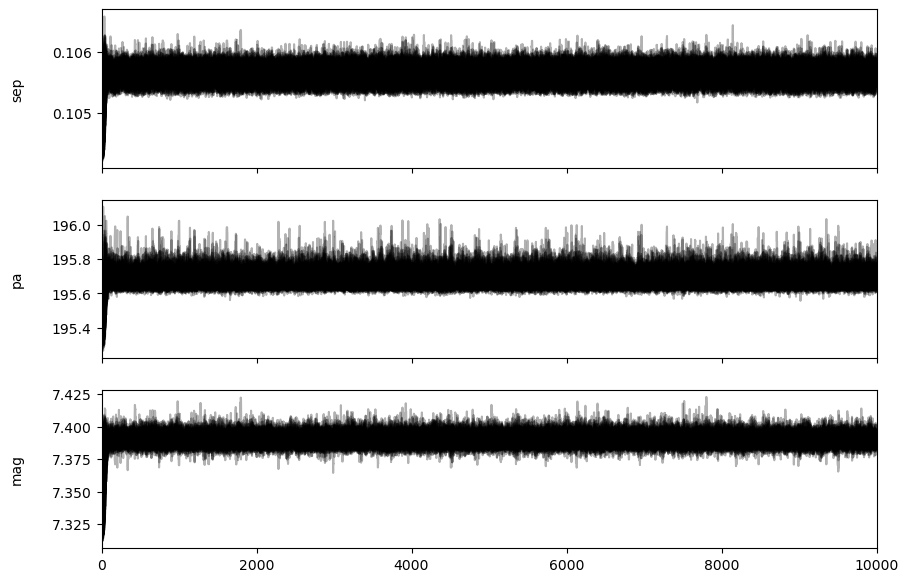

In [66]:
# plot initial chain
fig, axes = plt.subplots(ndim, figsize=(10,7), sharex=True)
labels = ['sep', 'pa', 'mag']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)



In [67]:
burnin = int(0.2 * samples.shape[0])
samples = samples[burnin:, :, :].reshape((-1, ndim))

sep_percen = np.percentile(samples[:, 0], [16.0, 50.0, 84.0])
ang_percen = np.percentile(samples[:, 1], [16.0, 50.0, 84.0])
mag_percen = np.percentile(samples[:, 2], [16.0, 50.0, 84.0])

print("Median and uncertainties (20% removed as burnin):")

print(
    f"Separation (mas) = {1e3*sep_percen[1]:.2f} "
    f"(-{1e3*sep_percen[1]-1e3*sep_percen[0]:.2f} "
    f"+{1e3*sep_percen[2]-1e3*sep_percen[1]:.2f})"
)

print(
    f"Position angle (deg) = {ang_percen[1]:.2f} "
    f"(-{ang_percen[1]-ang_percen[0]:.2f} "
    f"+{ang_percen[2]-ang_percen[1]:.2f})"
)

print(
    f"Contrast (mag) = {mag_percen[1]:.2f} "
    f"(-{mag_percen[1]-mag_percen[0]:.2f} "
    f"+{mag_percen[2]-mag_percen[1]:.2f})"
)


Median and uncertainties (20% removed as burnin):
Separation (mas) = 105.68 (-0.10 +0.07)
Position angle (deg) = 195.67 (-0.02 +0.03)
Contrast (mag) = 7.39 (-0.00 +0.00)


In [68]:
# results mcmc
sep = 0.10568
ang = 195.67
mag = 7.39
print(sep, ang, mag)

# doesn't work
# plot residuals
#pipeline = Pypeline(working_place_in, './', output_place)
#
#images = pipeline.get_data(f'science_crop_tc_masked')
#ref_data = pipeline.get_data(f'ref_crop_tc_masked')
#psf = pipeline.get_data(f'flux_crop_mean')
#parang = np.array(pipeline.list_attributes('science')['PARANG'])
#pixscale = pipeline.list_attributes('science')['PIXSCALE']
#
#im_shape = images.shape[-2:]
#print("imshape", im_shape)
#mask = create_mask(im_shape[-2:], (cent_size, edge_size))
#print(parang, pixscale)
#pipeline.run()


0.10568 195.67 7.39


In [69]:
#residual_im = residuals_rdi(np.array([sep_percen[1], ang_percen[1], mag_percen[1]]), images, ref_data,
#                            psf, mask, parang, psf_scaling, pixscale, pca_number,
#                            0.0, "mean")
#
#
#fits.writeto(f"output/{band}/mcmc_residuals_test.fits", residual_im, overwrite=True)

In [70]:
pipeline = Pypeline(working_place_in, './', output_place)
pipeline.list_attributes('offset')
offset = pipeline.get_data('offset')

print(pipeline.get_tags())

PynPoint v0.11.0

Working place: ./input/H/
Input place: ./
Output place: ./output/H/

Database: ./input/H/PynPoint_database.hdf5
Configuration: ./input/H/PynPoint_config.ini

Number of CPUs: 16
Number of threads: not set

----------------------------
Attribute overview of offset
----------------------------

Static attributes:

   - History: RemoveLinesModule = number of lines = (1, 0, 1, 0)

   - History: SystematicErrorModule = sep = 0.106, pa = 195.7, mag = 7.4

   - PIXSCALE = 0.01225

   - edge_size = 0.2

Non-static attributes:

   - FILES = [b'./input/H/sci.fits']

   - INDEX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

   - NFRAMES = [48]

   - PARANG = [-88.43361300287415, -88.88420060776635, -89.32008318229879, -89.7551380430906, -90.1935100705823, -90.6121540206833, -91.01742237768019, -91.42099490009593, -91.83356915483682, -92.222306

In [77]:
print(offset.shape)
degrees = np.linspace(0, 359, 360, endpoint=True)
labels = ['dsep', 'dpa', 'dmag', 'dx', 'dy']
labels2 = ['sep', 'pa', 'mag', 'x', 'y']
print(offset[0,:])

(360, 5)
[ 9.13260039e-05  1.12391732e+00 -1.77725677e-02 -1.69069445e-01
  9.11347517e-03]


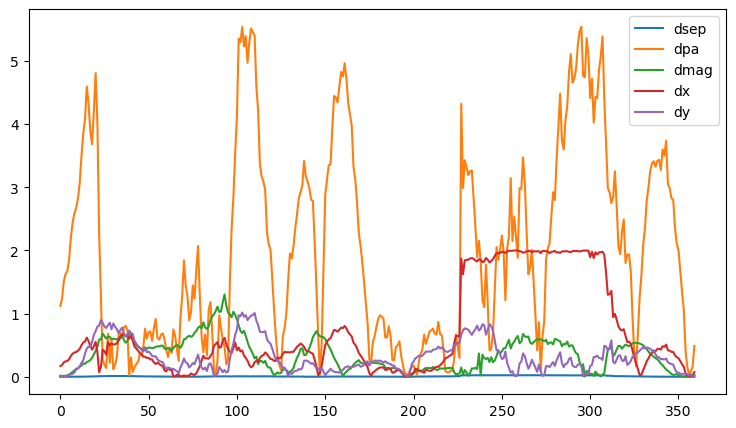

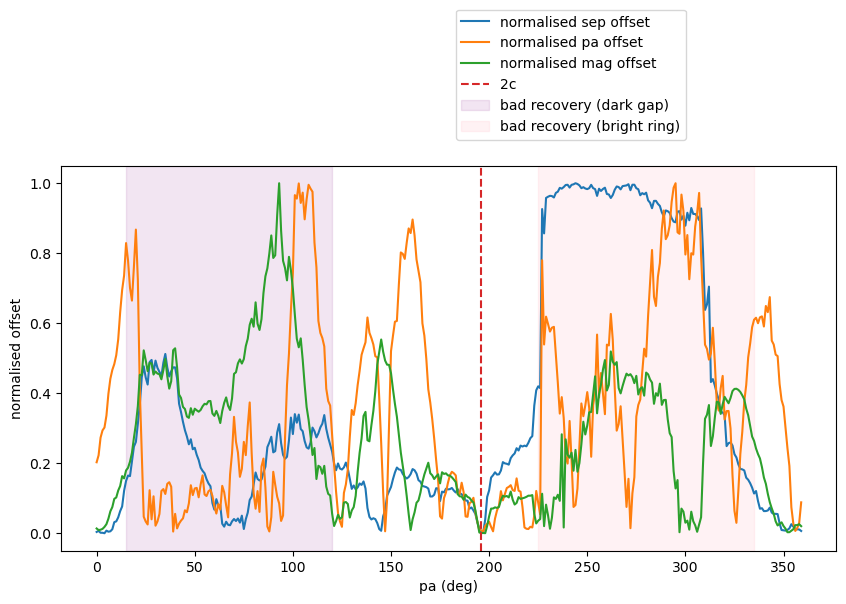

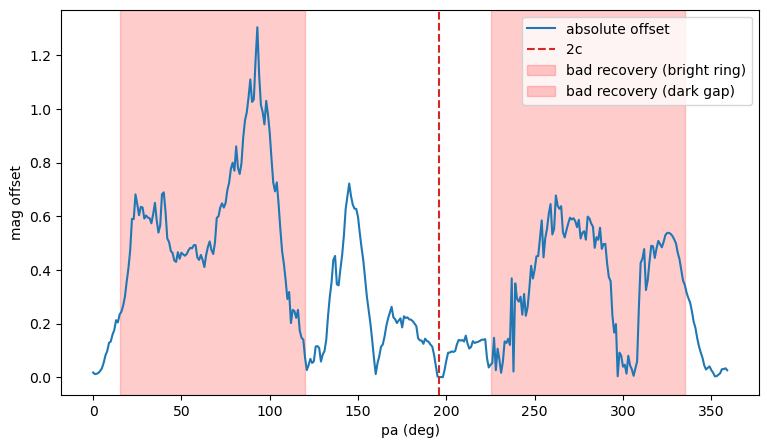

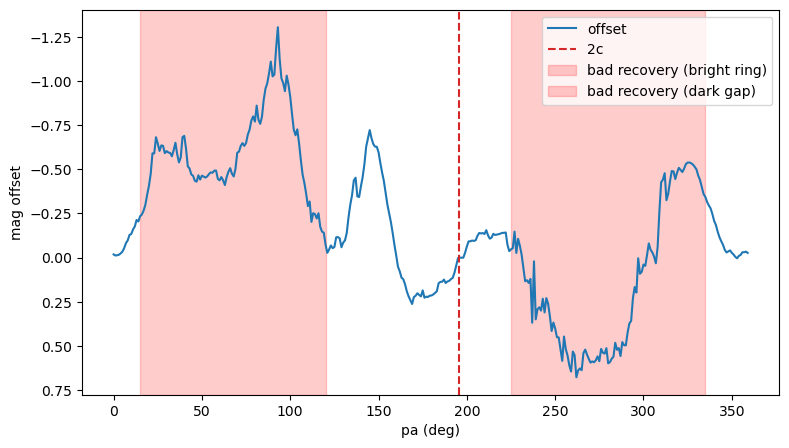

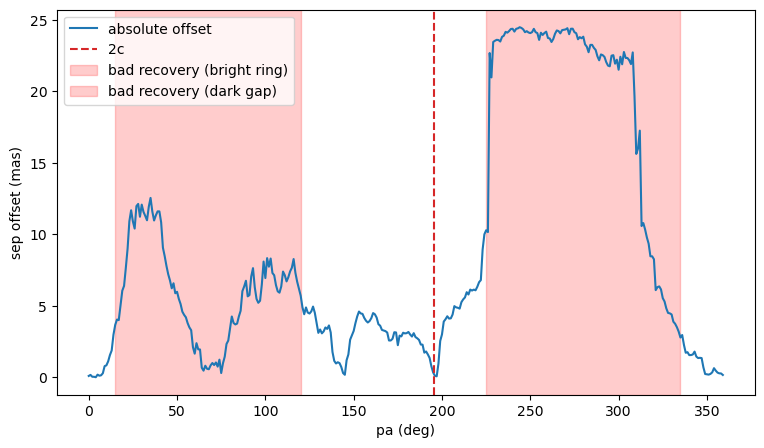

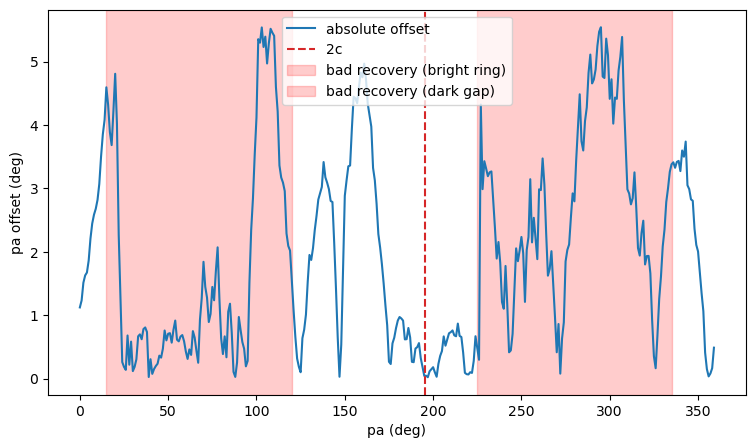

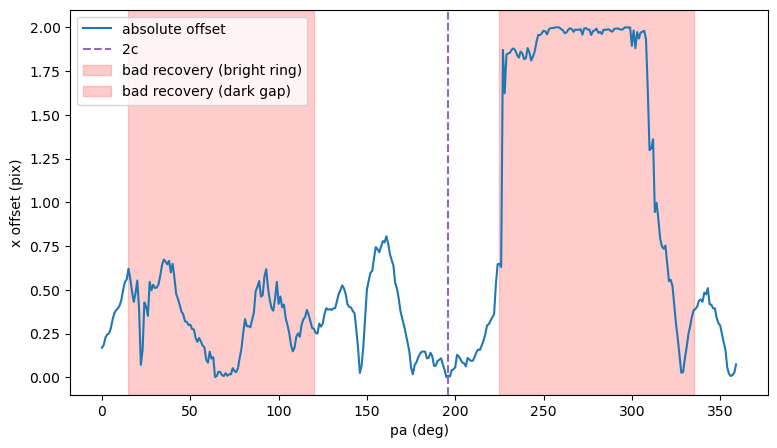

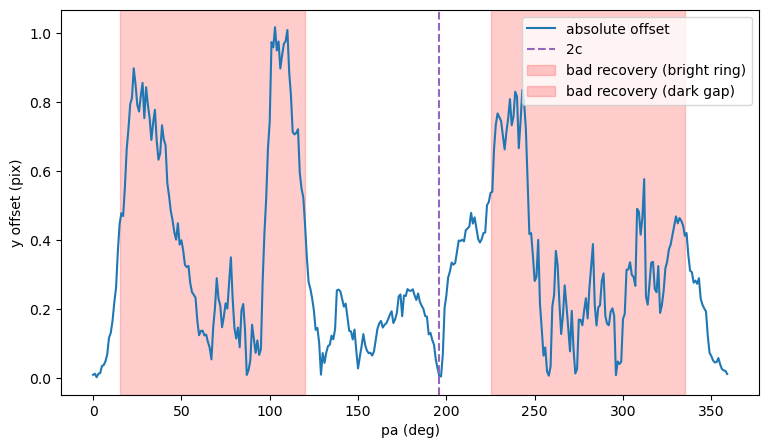

In [84]:
# plot errors as a function of angle
fig, ax = plt.subplots(1, figsize=(9,5))
for i in range(len(labels)):
    ax.plot(degrees, np.abs(offset[:,i]), label=labels[i])
plt.legend()
plt.show()

fig, ax = plt.subplots(1, figsize=(10,5))
for i in range(3):
    ax.plot(degrees, np.abs(offset[:,i])/np.max(np.abs(offset[:,i])), label="normalised "+labels2[i]+" offset")
ax.axvline(x=ang, ls="--", c="C3", label="2c")
ax.axvspan(xmin=15, xmax=120, color="purple", alpha=0.1, label="bad recovery (dark gap)")
ax.axvspan(xmin=225, xmax=335, color="pink", alpha=0.2, label="bad recovery (bright ring)")
ax.set_xlabel("pa (deg)")
ax.set_ylabel("normalised offset")
plt.legend(bbox_to_anchor=(0.5, 1.05))
plt.show()

# just mag
fig, ax = plt.subplots(1, figsize=(9,5))
ax.plot(degrees, np.abs(offset[:,2]), label="absolute offset")
ax.set_xlabel("pa (deg)")
ax.set_ylabel("mag offset")
ax.axvline(x=ang, ls="--", c="C3", label="2c")
ax.axvspan(xmin=225, xmax=335, color="red", alpha=0.2, label="bad recovery (bright ring)")
ax.axvspan(xmin=15, xmax=120, color="red", alpha=0.2, label="bad recovery (dark gap)")

ax.legend()
plt.show()

# just mag
fig, ax = plt.subplots(1, figsize=(9,5))
ax.plot(degrees, offset[:,2], label="offset")
ax.set_xlabel("pa (deg)")
ax.set_ylabel("mag offset")
ax.invert_yaxis()
ax.axvline(x=ang, ls="--", c="C3", label="2c")
ax.axvspan(xmin=225, xmax=335, color="red", alpha=0.2, label="bad recovery (bright ring)")
ax.axvspan(xmin=15, xmax=120, color="red", alpha=0.2, label="bad recovery (dark gap)")

ax.legend()
plt.show()

# just sep
fig, ax = plt.subplots(1, figsize=(9,5))
ax.plot(degrees, np.abs(offset[:,0])*1000, label="absolute offset")
ax.set_xlabel("pa (deg)")
ax.set_ylabel("sep offset (mas)")
ax.axvline(x=ang, ls="--", c="C3", label="2c")
ax.axvspan(xmin=225, xmax=335, color="red", alpha=0.2, label="bad recovery (bright ring)")
ax.axvspan(xmin=15, xmax=120, color="red", alpha=0.2, label="bad recovery (dark gap)")
ax.legend()
plt.show()

# just pa
fig, ax = plt.subplots(1, figsize=(9,5))
ax.plot(degrees, np.abs(offset[:,1]), label="absolute offset")
ax.set_xlabel("pa (deg)")
ax.set_ylabel("pa offset (deg)")
ax.axvline(x=ang, ls="--", c="C3", label="2c")
ax.axvspan(xmin=225, xmax=335, color="red", alpha=0.2, label="bad recovery (bright ring)")
ax.axvspan(xmin=15, xmax=120, color="red", alpha=0.2, label="bad recovery (dark gap)")
ax.legend()
plt.show()

# just x
fig, ax = plt.subplots(1, figsize=(9,5))
ax.plot(degrees, np.abs(offset[:,3]), label="absolute offset")
ax.set_xlabel("pa (deg)")
ax.set_ylabel("x offset (pix)")
ax.axvline(x=ang, ls="--", c="C4", label="2c")
ax.axvspan(xmin=225, xmax=335, color="red", alpha=0.2, label="bad recovery (bright ring)")
ax.axvspan(xmin=15, xmax=120, color="red", alpha=0.2, label="bad recovery (dark gap)")
ax.legend()
plt.show()

# just y
fig, ax = plt.subplots(1, figsize=(9,5))
ax.plot(degrees, np.abs(offset[:,4]), label="absolute offset")
ax.set_xlabel("pa (deg)")
ax.set_ylabel("y offset (pix)")
ax.axvline(x=ang, ls="--", c="C4", label="2c")
ax.axvspan(xmin=225, xmax=335, color="red", alpha=0.2, label="bad recovery (bright ring)")
ax.axvspan(xmin=15, xmax=120, color="red", alpha=0.2, label="bad recovery (dark gap)")
ax.legend()
plt.show()



In [73]:
sep_percen = np.percentile(offset[:, 0], [16.0, 50.0, 84.0])
ang_percen = np.percentile(offset[:, 1], [16.0, 50.0, 84.0])
mag_percen = np.percentile(offset[:, 2], [16.0, 50.0, 84.0])
x_pos_percen = np.percentile(offset[:, 3], [16.0, 50.0, 84.0])
y_pos_percen = np.percentile(offset[:, 4], [16.0, 50.0, 84.0])

print("\nMedian offset and uncertainties:")

print(
    f"   - Position x (pixels) = {x_pos_percen[1]:.2f} "
    f"(-{x_pos_percen[1]-x_pos_percen[0]:.2f} "
    f"+{x_pos_percen[2]-x_pos_percen[1]:.2f})"
)

print(
    f"   - Position y (pixels) = {y_pos_percen[1]:.2f} "
    f"(-{y_pos_percen[1]-y_pos_percen[0]:.2f} "
    f"+{y_pos_percen[2]-y_pos_percen[1]:.2f})"
)

print(
    f"   - Separation (mas) = {1e3*sep_percen[1]:.2f} "
    f"(-{1e3*sep_percen[1]-1e3*sep_percen[0]:.2f} "
    f"+{1e3*sep_percen[2]-1e3*sep_percen[1]:.2f})"
)

print(
    f"   - Position angle (deg) = {ang_percen[1]:.2f} "
    f"(-{ang_percen[1]-ang_percen[0]:.2f} "
    f"+{ang_percen[2]-ang_percen[1]:.2f})"
)

print(
    f"   - Contrast (mag) = {mag_percen[1]:.2f}"
    f"(-{mag_percen[1]-mag_percen[0]:.2f} "
    f"+{mag_percen[2]-mag_percen[1]:.2f})"
)


Median offset and uncertainties:
   - Position x (pixels) = -0.06 (-1.89 +0.45)
   - Position y (pixels) = -0.11 (-0.22 +0.53)
   - Separation (mas) = -5.32 (-17.50 +5.22)
   - Position angle (deg) = 0.19 (-3.17 +2.50)
   - Contrast (mag) = -0.13(-0.46 +0.36)


[[ 9.13260039e-05  1.12391732e+00 -1.77725677e-02 -1.69069445e-01
   9.11347517e-03]
 [ 1.63765408e-04  1.23425809e+00 -1.18034783e-02 -1.85777971e-01
   1.21266742e-02]
 [ 3.53317033e-05  1.51364467e+00 -1.31780629e-02 -2.27871397e-01
  -2.06037752e-03]
 [-3.28287050e-05  1.62844049e+00 -1.62681748e-02 -2.44941028e-01
  -1.20303788e-02]
 [-2.03350971e-06  1.67410586e+00 -2.36375604e-02 -2.51667909e-01
  -1.40734015e-02]
 [-1.81816938e-04  1.86369859e+00 -3.38869477e-02 -2.79082854e-01
  -3.47267040e-02]
 [-1.08556132e-04  2.20844350e+00 -5.44017871e-02 -3.30702310e-01
  -3.72191658e-02]
 [-1.35999888e-04  2.44689405e+00 -8.17852736e-02 -3.65645095e-01
  -4.81458564e-02]
 [-2.82142675e-04  2.58602656e+00 -9.77571953e-02 -3.84503467e-01
  -6.84011688e-02]
 [-7.78339162e-04  2.67883414e+00 -1.28283274e-01 -3.92716152e-01
  -1.16914768e-01]
 [-8.31763008e-04  2.81910396e+00 -1.33379161e-01 -4.11176355e-01
  -1.30763086e-01]
 [-1.11193068e-03  3.07068753e+00 -1.59262838e-01 -4.43478529e-01

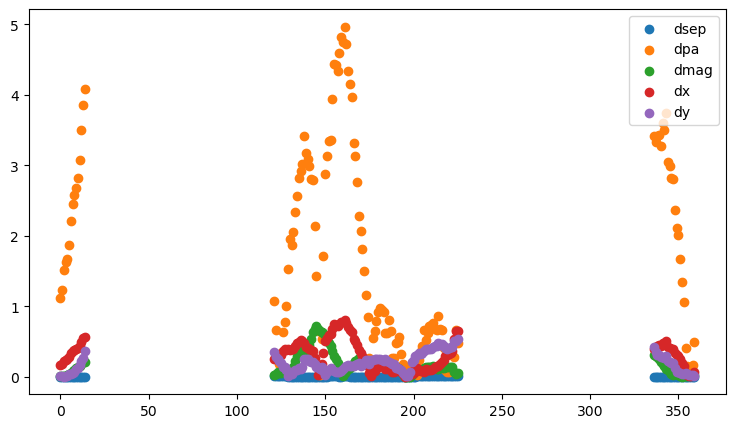


Median offset_cut and uncertainties:
   - Position x (pixels) = -0.04 (-0.46 +0.43)
   - Position y (pixels) = -0.09 (-0.14 +0.42)
   - Separation (mas) = -0.40 (-4.13 +3.52)
   - Position angle (deg) = 0.17 (-3.32 +1.71)
   - Contrast (mag) = -0.07(-0.22 +0.21)


In [75]:
#t1 = np.logical_and(offset>=0, offset<=15)
degrees_mask = np.logical_or.reduce((np.logical_and(degrees>=0, degrees<15), np.logical_and(degrees>120, degrees<=225), np.logical_and(degrees>335, degrees<=360)))
offset_cut = offset[degrees_mask]
degrees_cut = degrees[degrees_mask]
print(offset_cut)


# plot errors as a function of angle
fig, ax = plt.subplots(1, figsize=(9,5))
for i in range(len(labels)):
    ax.scatter(degrees_cut, np.abs(offset_cut[:,i]), label=labels[i])
plt.legend()
plt.show()

sep_percen = np.percentile(offset_cut[:, 0], [16.0, 50.0, 84.0])
ang_percen = np.percentile(offset_cut[:, 1], [16.0, 50.0, 84.0])
mag_percen = np.percentile(offset_cut[:, 2], [16.0, 50.0, 84.0])
x_pos_percen = np.percentile(offset_cut[:, 3], [16.0, 50.0, 84.0])
y_pos_percen = np.percentile(offset_cut[:, 4], [16.0, 50.0, 84.0])

print("\nMedian offset_cut and uncertainties:")

print(
    f"   - Position x (pixels) = {x_pos_percen[1]:.2f} "
    f"(-{x_pos_percen[1]-x_pos_percen[0]:.2f} "
    f"+{x_pos_percen[2]-x_pos_percen[1]:.2f})"
)

print(
    f"   - Position y (pixels) = {y_pos_percen[1]:.2f} "
    f"(-{y_pos_percen[1]-y_pos_percen[0]:.2f} "
    f"+{y_pos_percen[2]-y_pos_percen[1]:.2f})"
)

print(
    f"   - Separation (mas) = {1e3*sep_percen[1]:.2f} "
    f"(-{1e3*sep_percen[1]-1e3*sep_percen[0]:.2f} "
    f"+{1e3*sep_percen[2]-1e3*sep_percen[1]:.2f})"
)

print(
    f"   - Position angle (deg) = {ang_percen[1]:.2f} "
    f"(-{ang_percen[1]-ang_percen[0]:.2f} "
    f"+{ang_percen[2]-ang_percen[1]:.2f})"
)

print(
    f"   - Contrast (mag) = {mag_percen[1]:.2f}"
    f"(-{mag_percen[1]-mag_percen[0]:.2f} "
    f"+{mag_percen[2]-mag_percen[1]:.2f})"
)
